In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

In [18]:
# Load data from CSV file
csv_file = '/kaggle/input/nlp-neymar-chatbot-dataset/NLP_Neymar_ChatBot_Dataset.csv'  
df = pd.read_csv(csv_file)

In [33]:
df

,Question,Answer
0,What's your name?,I'm a chatbot here to provide information abou...
1,Who are you?,I'm a chatbot dedicated to discussing Neymar a...
2,Could you introduce yourself?,Sure! I'm a chatbot designed to assist with qu...
3,May I know your name?,Of course! I'm here to talk about Neymar and a...
4,What is Neymar's full name?,Neymar's full name is Neymar da Silva Santos J...
...,...,...
282,"What was the reported reason for Neymar, Ángel...","Neymar, Ángel Di María, and Leandro Paredes we..."
283,Who did Neymar support in the 2022 Brazilian g...,Neymar supported Guilherme Boulos in the 2022 ...
284,What is the title of the campaign launched by ...,The campaign launched by FIFA in conjunction w...
285,Which Brazilian singer did Neymar support by p...,Neymar supported sertanejo singer Gusttavo Lim...


In [19]:
# Preprocessing: Remove extra spaces
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [20]:
df['Question'] = df['Question'].apply(preprocess_text)
df['Answer'] = df['Answer'].apply(preprocess_text)

# Data Analysis 
print("Checking for null values...")
print(df.isnull().sum())

Checking for null values...
Question    0
Answer      0
dtype: int64


In [34]:
df.shape

(287, 2)

In [35]:
df.describe()

,Question,Answer
count,287,287
unique,273,277
top,Which full-length film featured Neymar playing...,Neymar won the FIFA Confederations Cup with Br...
freq,2,2


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  287 non-null    object
 1   Answer    287 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


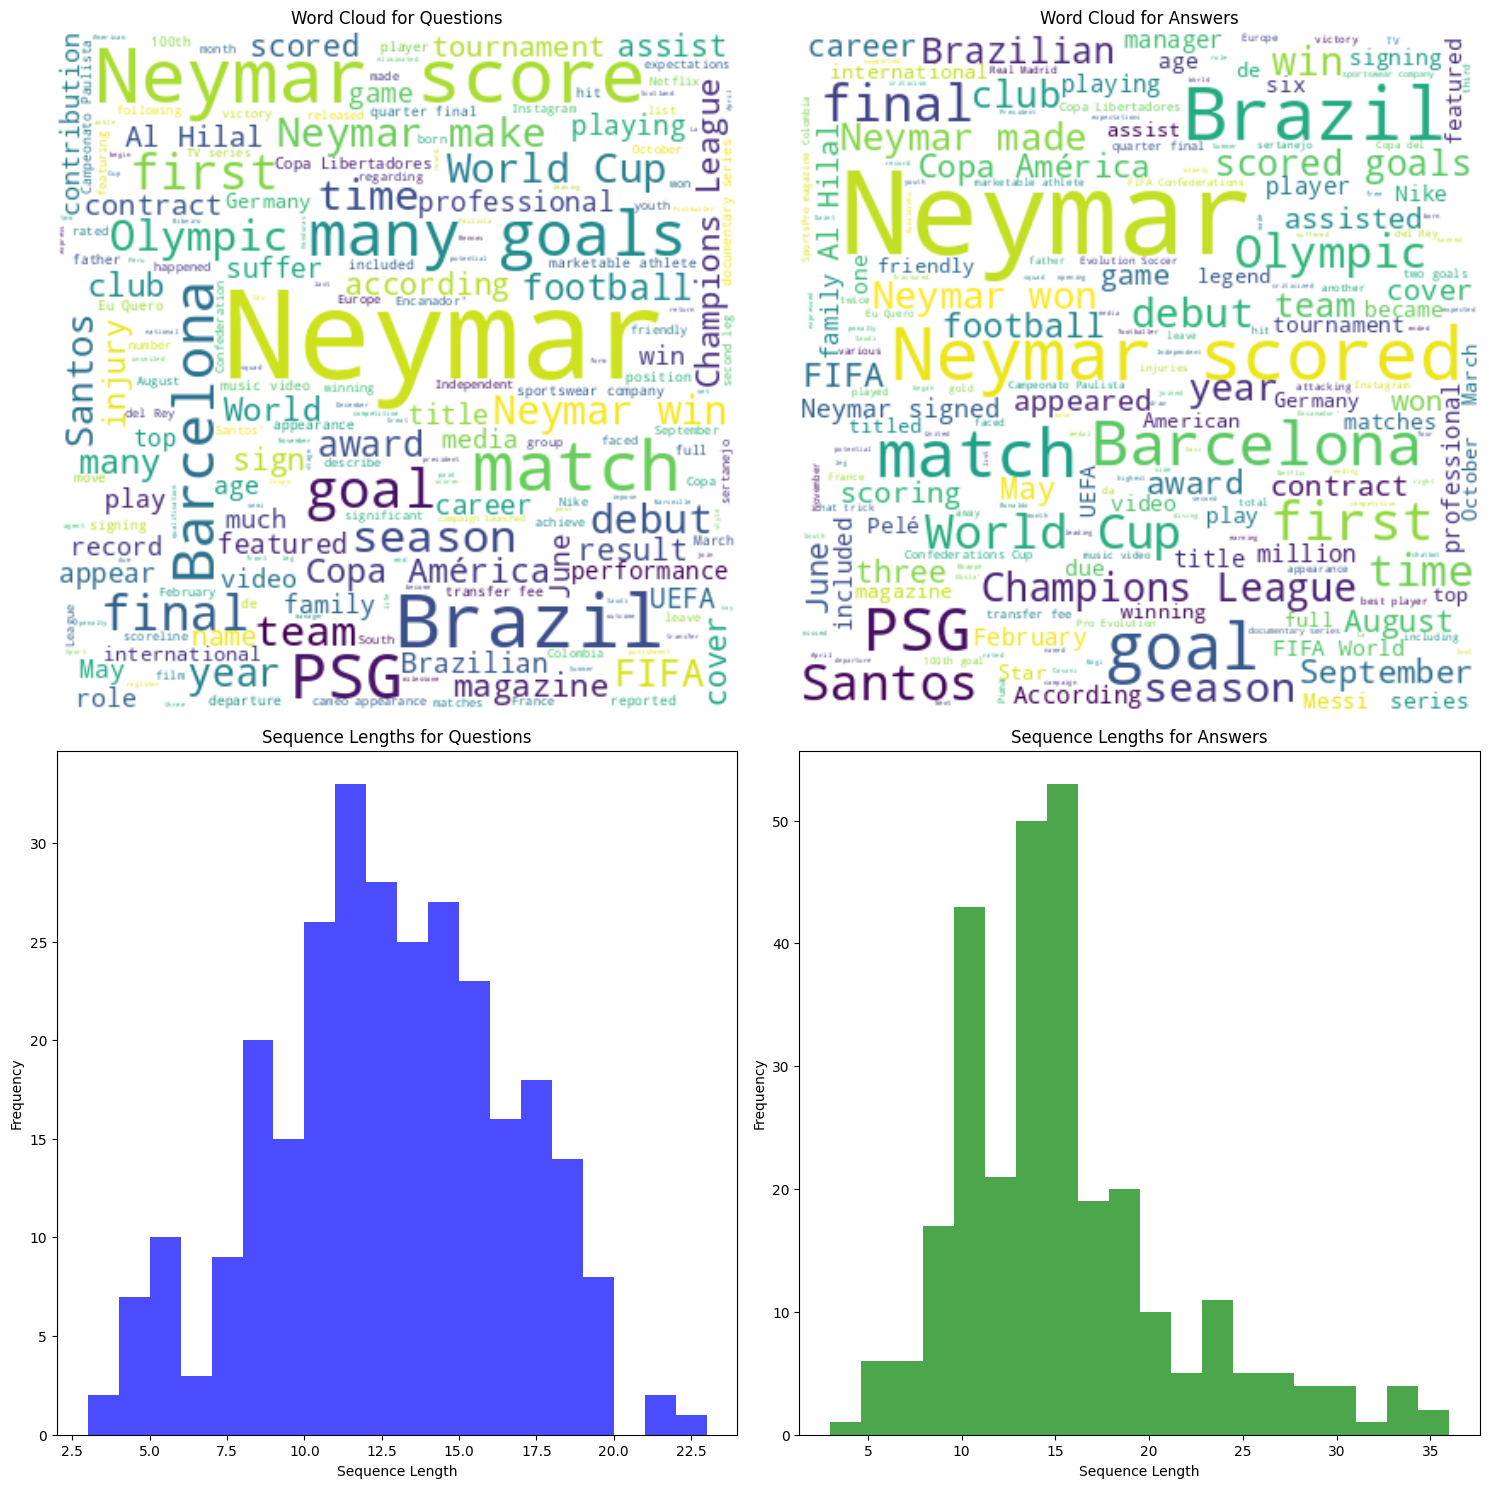

In [21]:
# Visualizations

# Word Cloud for Questions
question_text = ' '.join(df['Question'])
wordcloud_questions = WordCloud(width=400, height=400, background_color='white').generate(question_text)

# Word Cloud for Answers
answer_text = ' '.join(df['Answer'])
wordcloud_answers = WordCloud(width=400, height=400, background_color='white').generate(answer_text)

# Plot Sequence Lengths
question_lengths = [len(question.split()) for question in df['Question']]
answer_lengths = [len(answer.split()) for answer in df['Answer']]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot word clouds
axs[0, 0].imshow(wordcloud_questions, interpolation='bilinear')
axs[0, 0].axis('off')
axs[0, 0].set_title('Word Cloud for Questions')

axs[0, 1].imshow(wordcloud_answers, interpolation='bilinear')
axs[0, 1].axis('off')
axs[0, 1].set_title('Word Cloud for Answers')

# Plot sequence lengths
axs[1, 0].hist(question_lengths, bins=20, alpha=0.7, label='Questions', color='blue')
axs[1, 0].set_title('Sequence Lengths for Questions')
axs[1, 0].set_xlabel('Sequence Length')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(answer_lengths, bins=20, alpha=0.7, label='Answers', color='green')
axs[1, 1].set_title('Sequence Lengths for Answers')
axs[1, 1].set_xlabel('Sequence Length')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
# Split data into inputs and responses
inputs = df['Question'].tolist()
responses = df['Answer'].tolist()

In [23]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(inputs + responses)
vocab_size = len(tokenizer.word_index) + 1

input_sequences = tokenizer.texts_to_sequences(inputs)
response_sequences = tokenizer.texts_to_sequences(responses)

In [24]:
max_sequence_length = max(len(seq) for seq in (input_sequences + response_sequences))
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
response_sequences = pad_sequences(response_sequences, maxlen=max_sequence_length, padding='post')

In [25]:
# Convert responses to categorical (one-hot encoded)
response_sequences = np.array([np.eye(vocab_size)[seq] for seq in response_sequences])

In [27]:
# Build BiLSTM model
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(vocab_size, activation='softmax')
])

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 37, 128)        │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 37, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 37, 256)        │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 37, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 37, 1182)       │       152,478 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,982,236 (11.38 MB)

 Trainable params: 994,078 (3.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,988,158 (7.58 MB)

In [29]:
# Train the model
model.fit(input_sequences, response_sequences, epochs=300, batch_size=2)

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5528 - loss: 4.0064
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6130 - loss: 2.6843
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6138 - loss: 2.6024
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6276 - loss: 2.4239
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5987 - loss: 2.5984
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6081 - loss: 2.5041
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6196 - loss: 2.3976
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6299 - loss: 2.3183
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6140 - loss: 2.3857
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6193 - loss: 2.3391
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6259 - loss: 2.2657
Epoch 12/300
144/144 ━━━━━━━━━

In [30]:
# generate response
def generate_response(text):
    text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    predicted_sequence = model.predict(padded_sequence)
    response = tokenizer.sequences_to_texts([np.argmax(predicted_sequence, axis=2)[0]])
    return response[0]

In [41]:
print("You can chat with the bot. Type 'exit' to end the conversation.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break
    response = generate_response(user_input)
    print(f"Bot: {response}")

You can chat with the bot. Type 'exit' to end the conversation.


You:  What's your name?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Bot: i'm a chatbot here to provide information about neymar and more


You:  What is Neymar's full name?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: neymar's full name is neymar da silva santos júnior


You:  What is Neymar's height?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: neymar is 1 75 meters 5 feet 9 inches tall


You:  How many goals has Neymar scored for Brazil


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: neymar has scored 79 goals for brazil


You:  What problems were identified with Neymar's playing style in his first two seasons at Santos?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: problems identified with neymar's playing style included diving when tackled and attitude issues


You:  How much was the transfer fee for Neymar from Barcelona to PSG?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: the transfer fee for neymar from barcelona to psg was €222 million


You:  How many goals did Neymar score in his debut match for PSG?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: neymar scored one goal and assisted another in his debut match for psg


You:  What award did Neymar win at the 2014 World Cup?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: neymar won the bronze boot as the tournament's third top goalscorer and was named in the world cup cup all xi at 2014 2014 cup


You:  What was significant about Brazil's victory in the 2016 Olympic final?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: brazil's victory in the 2016 olympic final marked their first olympic gold medal in men's football


You:  Why was Neymar deregistered by Al Hilal in January 2024?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: neymar was deregistered by al hilal in january 2024 as a result of his season ending injury a order to free up one the the eight foreign roster spots for renan lodi


You:  What was the reported transfer fee for Neymar's move to Al Hilal?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: the reported transfer fee for neymar's move to al hilal was €90 million


You:  thanks


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: 


You:  exit


Goodbye!
